---

## Setup

In [1]:
%run ../setup_llm.py


🚀 LLM Setup Utility Test

🔍 Checking LLM Configuration...
📡 Provider: OpenAI (Direct)
✅ OPENAI_API_KEY is set

📋 Configuration:
   OPENAI_MODEL_NAME: gpt-4o

✅ OpenAI setup verified successfully!

📝 Testing model initialization...
✅ Model created: gpt-4o via OpenAI
✅ Test response: Hello


In [2]:
import sys
sys.path.insert(0, '..')  # Add parent directory to path for setup_llm

from setup_llm import get_chat_model  # Use LLM helper
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Literal, List
import operator
import os

# Initialize model
# Initialize model using DIAL (Azure OpenAI)
model = get_chat_model(temperature=0)

print("✅ Environment ready")


✅ Environment ready


---

## Pattern 1: Prompt Chaining

### What is Prompt Chaining?

**Prompt Chaining** decomposes a task into a sequence of steps, where each step's output feeds into the next.

```
PROMPT CHAINING PATTERN
══════════════════════════════════════════════════════════════

    Input
      │
      ▼
┌──────────┐    ┌──────────┐    ┌──────────┐    ┌──────────┐
│  Step 1  │───►│  Step 2  │───►│  Step 3  │───►│  Step 4  │
│ Generate │    │ Critique │    │ Revise   │    │ Format   │
└──────────┘    └──────────┘    └──────────┘    └──────────┘
                                                     │
                                                     ▼
                                                  Output
```

### When to Use

- Tasks with clear sequential steps
- When each step needs focused attention
- Complex tasks that benefit from decomposition
- Quality-critical outputs (generate → review → refine)

### Example: Document Processing Chain

Let's build a chain that:
1. **Summarizes** a document
2. **Extracts** key entities
3. **Generates** action items

In [3]:
# Define state for our chain
class ChainState(TypedDict):
    document: str
    summary: str
    entities: str
    action_items: str

# Step 1: Summarize
def summarize_step(state: ChainState) -> dict:
    """Summarize the document"""
    response = model.invoke([
        SystemMessage(content="You are a skilled summarizer. Create a concise summary."),
        HumanMessage(content=f"Summarize this document in 2-3 sentences:\n\n{state['document']}")
    ])
    return {"summary": response.content}

# Step 2: Extract entities
def extract_entities_step(state: ChainState) -> dict:
    """Extract key entities from the summary"""
    response = model.invoke([
        SystemMessage(content="You extract key entities (people, organizations, dates, topics)."),
        HumanMessage(content=f"Extract key entities from this summary:\n\n{state['summary']}")
    ])
    return {"entities": response.content}

# Step 3: Generate action items
def generate_actions_step(state: ChainState) -> dict:
    """Generate action items based on summary and entities"""
    response = model.invoke([
        SystemMessage(content="You create actionable next steps from documents."),
        HumanMessage(content=f"""Based on this summary and entities, suggest 3 action items:

Summary: {state['summary']}

Entities: {state['entities']}""")
    ])
    return {"action_items": response.content}

print("✅ Chain steps defined")

✅ Chain steps defined


In [5]:
# Build the chain graph
chain_builder = StateGraph(ChainState)

# Add nodes
chain_builder.add_node("summarize", summarize_step)
chain_builder.add_node("extract_entities", extract_entities_step)
chain_builder.add_node("generate_actions", generate_actions_step)

# Add edges (linear chain)
chain_builder.add_edge(START, "summarize")
chain_builder.add_edge("summarize", "extract_entities")
chain_builder.add_edge("extract_entities", "generate_actions")
chain_builder.add_edge("generate_actions", END)

# Compile
document_chain = chain_builder.compile()

print("✅ Document processing chain compiled")
print("\nFlow: summarize → extract_entities → generate_actions")

✅ Document processing chain compiled

Flow: summarize → extract_entities → generate_actions


In [5]:
document_chain.invoke?

Signature:
document_chain.invoke(
    input: 'InputT | Command | None',
    config: 'RunnableConfig | None' = None,
    *,
    context: 'ContextT | None' = None,
    stream_mode: 'StreamMode' = 'values',
    print_mode: 'StreamMode | Sequence[StreamMode]' = (),
    output_keys: 'str | Sequence[str] | None' = None,
    interrupt_before: 'All | Sequence[str] | None' = None,
    interrupt_after: 'All | Sequence[str] | None' = None,
    durability: 'Durability | None' = None,
    **kwargs: 'Any',
) -> 'dict[str, Any] | Any'
Docstring:
Run the graph with a single input and config.

Args:
    input: The input data for the graph. It can be a dictionary or any other type.
    config: The configuration for the graph run.
    context: The static context to use for the run.
        !!! version-added "Added in version 0.6.0"
    stream_mode: The stream mode for the graph run.
    print_mode: Accepts the same values as `stream_mode`, but only prints the output to the console, for debugging purposes

In [6]:
# Test the chain
sample_document = """
Meeting Notes - Q4 Planning Session
Date: November 15, 2024
Attendees: Sarah (CEO), Mike (CTO), Lisa (VP Product)

Key Discussions:
1. AI Integration: Mike proposed integrating GPT-4 into our customer service platform.
   Budget estimate: $50,000. Timeline: Q1 2025.

2. Product Roadmap: Lisa presented three new features for the mobile app.
   Priority: Push notifications, dark mode, offline support.

3. Hiring Plans: Sarah approved hiring 5 engineers by January.
   Focus areas: ML engineers (2), Backend (2), Frontend (1).

Next Steps:
- Mike to prepare AI integration proposal by Nov 30
- Lisa to finalize feature specs by Nov 22
- HR to post job listings by Nov 18
"""

result = document_chain.invoke({
    "document": sample_document,
    "summary": "",
    "entities": "",
    "action_items": ""
})

print("📄 DOCUMENT PROCESSING RESULTS")
print("=" * 60)
print(f"\n📝 SUMMARY:\n{result['summary']}")
print(f"\n🏷️ ENTITIES:\n{result['entities']}")
print(f"\n✅ ACTION ITEMS:\n{result['action_items']}")

📄 DOCUMENT PROCESSING RESULTS

📝 SUMMARY:
In the Q4 planning session, the team discussed integrating GPT-4 into the customer service platform (budget: $50,000, timeline: Q1 2025), prioritized three new mobile app features (push notifications, dark mode, offline support), and approved hiring five engineers by January. Action items include preparing an AI proposal, finalizing feature specs, and posting job listings.

🏷️ ENTITIES:
**Key Entities:**

- **People/Groups:** The team  
- **Organizations:** Not explicitly mentioned  
- **Dates:** Q4, Q1 2025, January  
- **Topics:**  
  - Integrating GPT-4 into the customer service platform  
  - Budget: $50,000  
  - Timeline: Q1 2025  
  - New mobile app features: push notifications, dark mode, offline support  
  - Hiring five engineers  
  - Action items: preparing an AI proposal, finalizing feature specs, posting job listings  

✅ ACTION ITEMS:
Here are three actionable next steps based on the summary and entities:

1. **Prepare and Submit

---

## Pattern 2: Routing

### What is Routing?

**Routing** directs inputs to specialized handlers based on the input characteristics.

```
ROUTING PATTERN
══════════════════════════════════════════════════════════════

                         Input
                           │
                           ▼
                    ┌──────────┐
                    │ Classify │
                    └────┬─────┘
                         │
          ┌──────────────┼──────────────┐
          ▼              ▼              ▼
    ┌──────────┐  ┌──────────┐  ┌──────────┐
    │ Handler  │  │ Handler  │  │ Handler  │
    │    A     │  │    B     │  │    C     │
    └────┬─────┘  └────┬─────┘  └────┬─────┘
          │              │              │
          └──────────────┴──────────────┘
                         │
                         ▼
                      Output
```

### When to Use

- Different input types need different processing
- Specialized models/prompts for each category
- Efficiency: lighter handlers for simple tasks
- Examples: support tickets, content moderation, query handling

### Example: Customer Support Router

Route customer queries to specialized handlers:
- **Technical** → Tech support with detailed troubleshooting
- **Billing** → Billing team with account lookup
- **General** → General FAQ responses

In [7]:
from pydantic import BaseModel, Field
from enum import Enum

# Define categories
class QueryCategory(str, Enum):
    TECHNICAL = "technical"
    BILLING = "billing"
    GENERAL = "general"

class ClassificationResult(BaseModel):
    """Result of query classification"""
    category: QueryCategory = Field(description="The category of the query")
    confidence: float = Field(description="Confidence score 0-1")
    reasoning: str = Field(description="Brief explanation of classification")

# State for router
class RouterState(TypedDict):
    query: str
    category: str
    confidence: float
    response: str

print("✅ Router types defined")

✅ Router types defined


In [8]:
# Classifier using structured output
# Use method="function_calling" for broader compatibility (DIAL/Azure OpenAI)
classifier = model.with_structured_output(ClassificationResult, method="function_calling")

def classify_query(state: RouterState) -> dict:
    """Classify the customer query"""
    result = classifier.invoke([
        SystemMessage(content="""Classify customer support queries into categories:
- technical: Software bugs, installation issues, feature questions, error messages
- billing: Payments, invoices, subscriptions, refunds, pricing
- general: Product info, company questions, feedback, other"""),
        HumanMessage(content=f"Classify this query: {state['query']}")
    ])
    return {
        "category": result.category.value,
        "confidence": result.confidence
    }

# Specialized handlers
def handle_technical(state: RouterState) -> dict:
    """Technical support handler"""
    response = model.invoke([
        SystemMessage(content="""You are a technical support specialist. 
Provide detailed troubleshooting steps. Be thorough and technical."""),
        HumanMessage(content=state["query"])
    ])
    return {"response": f"🔧 [Technical Support]\n\n{response.content}"}

def handle_billing(state: RouterState) -> dict:
    """Billing handler"""
    response = model.invoke([
        SystemMessage(content="""You are a billing specialist.
Be helpful with payment and subscription questions. Mention that account details can be verified."""),
        HumanMessage(content=state["query"])
    ])
    return {"response": f"💳 [Billing Support]\n\n{response.content}"}

def handle_general(state: RouterState) -> dict:
    """General handler"""
    response = model.invoke([
        SystemMessage(content="""You are a friendly customer service representative.
Be helpful and concise. Offer to connect to specialists if needed."""),
        HumanMessage(content=state["query"])
    ])
    return {"response": f"💬 [General Support]\n\n{response.content}"}

print("✅ Classification and handlers defined")

✅ Classification and handlers defined


In [9]:
# Build the router graph
router_builder = StateGraph(RouterState)

# Add nodes
router_builder.add_node("classify", classify_query)
router_builder.add_node("technical", handle_technical)
router_builder.add_node("billing", handle_billing)
router_builder.add_node("general", handle_general)

# Routing function
def route_to_handler(state: RouterState) -> Literal["technical", "billing", "general"]:
    return state["category"]

# Add edges
router_builder.add_edge(START, "classify")
router_builder.add_conditional_edges(
    "classify",
    route_to_handler,
    {
        "technical": "technical",
        "billing": "billing",
        "general": "general"
    }
)
router_builder.add_edge("technical", END)
router_builder.add_edge("billing", END)
router_builder.add_edge("general", END)

# Compile
support_router = router_builder.compile()

print("✅ Support router compiled")

try:
    display(Image(support_router.get_graph().draw_mermaid_png()))
except Exception:
    print(support_router.get_graph().draw_mermaid())

✅ Support router compiled
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	classify(classify)
	technical(technical)
	billing(billing)
	general(general)
	__end__([<p>__end__</p>]):::last
	__start__ --> classify;
	classify -.-> billing;
	classify -.-> general;
	classify -.-> technical;
	billing --> __end__;
	general --> __end__;
	technical --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [10]:
# Test the router with different queries
test_queries = [
    "My app keeps crashing when I try to upload files larger than 10MB",
    "I was charged twice for my subscription last month",
    "What are your business hours?"
]

print("🔀 ROUTING DEMO")
print("=" * 60)

for query in test_queries:
    result = support_router.invoke({
        "query": query,
        "category": "",
        "confidence": 0.0,
        "response": ""
    })
    
    print(f"\n📩 Query: {query}")
    print(f"📊 Routed to: {result['category']} (confidence: {result['confidence']:.0%})")
    print(f"\n{result['response'][:300]}..." if len(result['response']) > 300 else f"\n{result['response']}")
    print("\n" + "-" * 60)

🔀 ROUTING DEMO

📩 Query: My app keeps crashing when I try to upload files larger than 10MB
📊 Routed to: technical (confidence: 95%)

🔧 [Technical Support]

I'm sorry to hear that you're experiencing issues with your app. Let's go through a detailed troubleshooting process to identify and resolve the problem. Please follow these steps:

### Step 1: Check App Requirements and Limitations
1. **Review Documentation**: Check the app's...

------------------------------------------------------------

📩 Query: I was charged twice for my subscription last month
📊 Routed to: billing (confidence: 95%)

💳 [Billing Support]

I'm sorry to hear about the double charge. Let's get that sorted out for you. Could you please verify your account details, such as the email address associated with your subscription? Once I have that information, I can look into the charges and help resolve the issue.

------------------------------------------------------------

📩 Query: What are your business hours?
📊 Rout

---

## Pattern 3: Parallelization

### What is Parallelization?

**Parallelization** runs multiple LLM calls simultaneously for tasks that are independent.

```
PARALLELIZATION PATTERN
══════════════════════════════════════════════════════════════

                         Input
                           │
          ┌────────────────┼────────────────┐
          ▼                ▼                ▼
    ┌──────────┐    ┌──────────┐    ┌──────────┐
    │  Task A  │    │  Task B  │    │  Task C  │
    │ (async)  │    │ (async)  │    │ (async)  │
    └────┬─────┘    └────┬─────┘    └────┬─────┘
          │                │                │
          └────────────────┴────────────────┘
                           │
                           ▼
                    ┌──────────┐
                    │ Combine  │
                    └────┬─────┘
                         │
                         ▼
                      Output
```

### Two Types of Parallelization

1. **Sectioning**: Split task into independent subtasks
   - Example: Analyze document from multiple perspectives

2. **Voting**: Run same task multiple times, aggregate results
   - Example: Multiple reviewers, take majority vote

### Example: Multi-Perspective Analysis (Sectioning)

Analyze a business proposal from multiple perspectives in parallel.

In [7]:
import asyncio
from typing import List

# State for parallel analysis
class AnalysisState(TypedDict):
    proposal: str
    financial_analysis: str
    risk_analysis: str
    market_analysis: str
    final_recommendation: str

# Parallel analysis nodes
def analyze_financial(state: AnalysisState) -> dict:
    """Financial perspective analysis"""
    response = model.invoke([
        SystemMessage(content="You are a CFO analyzing financial viability. Focus on ROI, costs, and financial risks."),
        HumanMessage(content=f"Analyze this proposal from a financial perspective:\n\n{state['proposal']}")
    ])
    return {"financial_analysis": response.content}

def analyze_risk(state: AnalysisState) -> dict:
    """Risk perspective analysis"""
    response = model.invoke([
        SystemMessage(content="You are a Risk Officer. Identify potential risks and mitigation strategies."),
        HumanMessage(content=f"Analyze this proposal for risks:\n\n{state['proposal']}")
    ])
    return {"risk_analysis": response.content}

def analyze_market(state: AnalysisState) -> dict:
    """Market perspective analysis"""
    response = model.invoke([
        SystemMessage(content="You are a Market Analyst. Assess market opportunity and competitive landscape."),
        HumanMessage(content=f"Analyze the market potential:\n\n{state['proposal']}")
    ])
    return {"market_analysis": response.content}

def synthesize_recommendation(state: AnalysisState) -> dict:
    """Combine all analyses into final recommendation"""
    response = model.invoke([
        SystemMessage(content="You are a CEO making the final decision. Synthesize all perspectives."),
        HumanMessage(content=f"""Based on these analyses, provide a final recommendation:

FINANCIAL ANALYSIS:
{state['financial_analysis']}

RISK ANALYSIS:
{state['risk_analysis']}

MARKET ANALYSIS:
{state['market_analysis']}

Provide a clear GO/NO-GO recommendation with key reasons.""")
    ])
    return {"final_recommendation": response.content}

print("✅ Analysis functions defined")

✅ Analysis functions defined


In [8]:
# Build parallel analysis graph
# LangGraph handles parallelization when multiple nodes can run from the same source

parallel_builder = StateGraph(AnalysisState)

# Add nodes
parallel_builder.add_node("financial", analyze_financial)
parallel_builder.add_node("risk", analyze_risk)
parallel_builder.add_node("market", analyze_market)
parallel_builder.add_node("synthesize", synthesize_recommendation)

# All three analyses run from START (parallel)
parallel_builder.add_edge(START, "financial")
parallel_builder.add_edge(START, "risk")
parallel_builder.add_edge(START, "market")

# All analyses feed into synthesis
parallel_builder.add_edge("financial", "synthesize")
parallel_builder.add_edge("risk", "synthesize")
parallel_builder.add_edge("market", "synthesize")

parallel_builder.add_edge("synthesize", END)

# Compile
analysis_graph = parallel_builder.compile()

print("✅ Parallel analysis graph compiled")

✅ Parallel analysis graph compiled


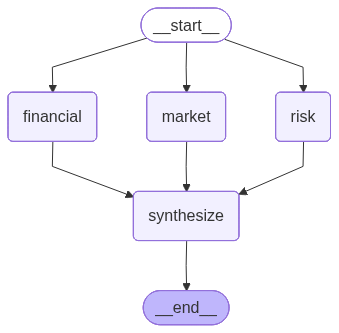

In [9]:
# Visualize the parallel graph
from IPython.display import Image, display

try:
    display(Image(analysis_graph.get_graph().draw_mermaid_png()))
except Exception:
    print(analysis_graph.get_graph().draw_mermaid())

In [11]:
# Test with a business proposal
sample_proposal = """
PROJECT PROPOSAL: AI-Powered Customer Service Platform

Investment Required: $500,000
Timeline: 6 months
Expected ROI: 200% over 2 years

Description:
Deploy an AI chatbot to handle 70% of customer inquiries, reducing support staff 
needs by 40%. Integration with existing CRM and ticketing systems.

Key Features:
- 24/7 availability
- Multi-language support
- Seamless human handoff
- Analytics dashboard

Competition:
- Zendesk AI (established)
- Intercom (growing)
- Our differentiation: Custom industry knowledge
"""

print("⏳ Running parallel analysis (3 perspectives simultaneously)...")
print("   This demonstrates the power of parallel processing!\n")

result = analysis_graph.invoke({
    "proposal": sample_proposal,
    "financial_analysis": "",
    "risk_analysis": "",
    "market_analysis": "",
    "final_recommendation": ""
})

print("📊 MULTI-PERSPECTIVE ANALYSIS COMPLETE")
print("=" * 60)

⏳ Running parallel analysis (3 perspectives simultaneously)...
   This demonstrates the power of parallel processing!

📊 MULTI-PERSPECTIVE ANALYSIS COMPLETE


In [12]:
# Display results
print("\n💰 FINANCIAL ANALYSIS:")
print("-" * 40)
print(result['financial_analysis'][:500] + "..." if len(result['financial_analysis']) > 500 else result['financial_analysis'])


💰 FINANCIAL ANALYSIS:
----------------------------------------
### Financial Analysis of the AI-Powered Customer Service Platform Proposal

#### **1. Investment Overview**
- **Initial Investment Required**: $500,000
- **Timeline**: 6 months to deploy
- **Expected ROI**: 200% over 2 years (equivalent to $1,000,000 in returns, or $500,000 in net profit).

The proposal suggests a significant upfront investment with a high ROI projection. However, the financial viability depends on the accuracy of the cost savings, revenue generation, and competitive positionin...


In [14]:
print("\n⚠️ RISK ANALYSIS:")
print("-" * 40)
print(result['risk_analysis'][:500] + "..." if len(result['risk_analysis']) > 500 else result['risk_analysis'])


⚠️ RISK ANALYSIS:
----------------------------------------
### Risk Analysis for AI-Powered Customer Service Platform Proposal

#### **1. Financial Risks**
- **Risk:** The $500,000 investment may exceed budget due to unforeseen development costs, integration challenges, or scope creep.
  - **Mitigation:** Conduct a detailed cost analysis and allocate a contingency budget (e.g., 10-15% of the total investment). Implement strict project management controls to avoid scope creep.
- **Risk:** ROI projections (200% over 2 years) may be overly optimistic if ad...


In [15]:
print("\n📈 MARKET ANALYSIS:")
print("-" * 40)
print(result['market_analysis'][:500] + "..." if len(result['market_analysis']) > 500 else result['market_analysis'])


📈 MARKET ANALYSIS:
----------------------------------------
### Market Opportunity Analysis: AI-Powered Customer Service Platform

#### **Market Trends**
1. **Growing Demand for AI in Customer Service**:
   - The global AI in customer service market is projected to grow at a CAGR of 23-25% from 2023 to 2030, driven by the need for cost efficiency, improved customer experience, and scalability.
   - Businesses are increasingly adopting AI chatbots to handle repetitive inquiries, reduce operational costs, and provide 24/7 support.

2. **Cost Reduction and ...


In [16]:
print("\n🎯 FINAL RECOMMENDATION:")
print("=" * 60)
print(result['final_recommendation'])


🎯 FINAL RECOMMENDATION:
### Final Recommendation: **GO**

#### Key Reasons for Approval:
1. **High ROI Potential**: The projected 200% ROI over 2 years is highly attractive, even with conservative adjustments to assumptions. The financial analysis indicates strong revenue potential, especially with a SaaS model targeting 100 clients at an average subscription of $1,000/month, yielding $1.2 million annually.

2. **Market Opportunity**: The AI-powered customer service market is growing rapidly, with a projected CAGR of 23-25% through 2030. The demand for cost-efficient, scalable, and personalized solutions aligns perfectly with the platform’s features, particularly custom industry knowledge and multi-language support.

3. **Differentiation**: The platform’s focus on custom industry knowledge and seamless human handoff addresses key pain points that competitors like Zendesk and Intercom struggle to solve. This differentiation positions the platform to carve out a niche in industries requ

---

## Pattern Summary

| Pattern | Use Case | Key Benefit |
|---------|----------|-------------|
| **Prompt Chaining** | Sequential tasks with dependencies | Quality through iteration |
| **Routing** | Different handling per category | Specialized responses |
| **Parallelization** | Independent subtasks | Speed & diverse perspectives |

### Combining Patterns

In production, these patterns are often combined:

```
Input → [ROUTE] → Category A → [PARALLEL ANALYSIS] → [CHAIN] → Output
                → Category B → [SIMPLE HANDLER] → Output
                → Category C → [CHAIN] → Output
```

---

## 🎯 Key Takeaways

### Workflow Patterns

1. **Prompt Chaining**
   - Sequential steps where output feeds into next step
   - Great for: generate → critique → revise patterns
   - Enables focused attention on each step

2. **Routing**
   - Classify input and direct to specialized handlers
   - Use structured output for reliable classification
   - Enable different prompts/models per category

3. **Parallelization**
   - Run independent tasks simultaneously
   - Sectioning: different perspectives on same input
   - Voting: same task multiple times, aggregate

### When to Use Workflows vs. Agents

| Use Workflows When | Use Agents When |
|-------------------|----------------|
| Steps are predictable | Dynamic decision-making needed |
| Need reliability | Tasks require tool selection |
| Debugging is priority | Complex reasoning needed |
| Fixed business logic | Adaptive behavior required |

### What's Next

In **Module 3**, we'll explore **Multi-Agent Systems**:
- Supervisor pattern
- Agent handoffs
- Planning with specialized agents

---

## Practice Exercise

**Challenge**: Build a content review workflow that:

1. **Routes** content by type (blog post, tweet, email)
2. For blog posts: **Chain** of (grammar check → tone adjustment → SEO optimization)
3. For tweets: Simple length check + suggestion
4. For emails: **Parallel** check (tone + grammar + professionalism)

In [19]:
# Your solution here:

class ContentReviewState(TypedDict):
    content: str
    content_type: str
    review_result: str

# TODO: Implement the content review workflow
# 1. Create a classifier for content type
# 2. Create handlers for each type with appropriate patterns
# 3. Build and compile the graph

print("💡 Implement your content review workflow above!")

💡 Implement your content review workflow above!
